### Import Packages


In [ ]:
import cv2, os, sys
import pandas as pd
import json
import numpy as np
import random
from tqdm.auto import tqdm
import shutil as sh
from PIL import Image  
import matplotlib.pyplot as plt
# from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision


### Import your drive's contents!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from drive.MyDrive.AMI.bbox_folder import bbox
os.chdir('/content/drive/MyDrive/AMI')
from bbox_folder import bbox

### Set the seed and device

In [ ]:
# set the seed of the random number generator to a fixed value, the results will be reproducible.
SEED = 1
def set_seed(SEED):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)  # for generating random numbers
    torch.cuda.manual_seed(SEED)  # for generating random numbers for the current GPU
    torch.cuda.manual_seed_all(SEED)  # for generating random numbers on all GPUs
    # cudnn.deterministic: CuDNN algorithms are deterministic
    # get the same result if run the same CuDNN-ops with the same inputs on the same system
    torch.backends.cudnn.deterministic = True
    # cudnn.benchmark is good whenever input sizes for the network do not vary 
    # cudnn look for the optimal set of algorithms for that particular configuration. This leads to faster runtime.
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current Device : {}'.format(device))

Current Device : cuda:0


### Load the dataset


In [ ]:
file_path = '/content/drive/MyDrive/AMI/save_label_H.csv' 
data_label = pd.read_csv(file_path)

annotation_path = '/content/drive/MyDrive/AMI/annotated_functional_test3_fixed.json' 
data_image = bbox(annotation_path)

data = pd.concat([data_image[['file_name', 'id']].reset_index(), data_label[['human_label','label_name']].reset_index()], axis=1)
train_data = data.drop(columns='index')
train_data

,file_name,id,human_label,label_name
0,8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...,504548,2,Other
1,f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...,504081,2,Other
2,f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...,504082,1,Dent
3,f58a99ab-350a-41df-8dbf-889326378c4a/e84bd41d-...,504086,4,Scratch
4,b44a2093-2861-402b-96bd-23cac6359b94/e84bd41d-...,504658,1,Dent
...,...,...,...,...
892,5acc593f-c057-46db-81e5-3d657ddeae6b/3ab29178-...,504436,4,Scratch
893,39795355-5bde-47a1-8e5e-ec67b86801af/be80b6a0-...,504309,3,Rim
894,3e194ab1-9afa-4b28-aab4-48216990b6d6/fe18c3ff-...,504352,4,Scratch
895,3e194ab1-9afa-4b28-aab4-48216990b6d6/fe18c3ff-...,504353,3,Rim


In [ ]:
# pytorch tensor: 1234->0123
train_data['label'] = train_data.human_label.apply(lambda x: x-1)
train_data.drop(columns=['human_label'], inplace=True)
train_data

,file_name,id,label_name,label
0,8f27c5f1-3ea3-4392-9bc8-585c76057cd1/858a0246-...,504548,Other,1
1,f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...,504081,Other,1
2,f58a99ab-350a-41df-8dbf-889326378c4a/858a0246-...,504082,Dent,0
3,f58a99ab-350a-41df-8dbf-889326378c4a/e84bd41d-...,504086,Scratch,3
4,b44a2093-2861-402b-96bd-23cac6359b94/e84bd41d-...,504658,Dent,0
...,...,...,...,...
892,5acc593f-c057-46db-81e5-3d657ddeae6b/3ab29178-...,504436,Scratch,3
893,39795355-5bde-47a1-8e5e-ec67b86801af/be80b6a0-...,504309,Rim,2
894,3e194ab1-9afa-4b28-aab4-48216990b6d6/fe18c3ff-...,504352,Scratch,3
895,3e194ab1-9afa-4b28-aab4-48216990b6d6/fe18c3ff-...,504353,Rim,2


In [ ]:
resize_width = 240  # 255
resize_height = 240  # 236
batch_size = 64
learning_rate = 0.005
epochs = 10

os.chdir('/content/drive/MyDrive/AMI/bbox_image')

class bbox_dataset(Dataset):
    def __init__(self, train_data):
        self.train_data = train_data
        self.tensor_transform = T.Compose([T.Resize([resize_width, resize_height], interpolation=T.InterpolationMode.BICUBIC), \
            # T.Grayscale(num_output_channels=1), \  # CNN don't need gray, need 3 channels
            T.ToTensor()])
        self.normalize_transform = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __len__(self):       
        return self.train_data.shape[0]

    def __getitem__(self, idx):
        fp  = self.train_data.file_name[idx]

        _, ext = os.path.splitext(fp) 
        name = str(train_data.id[idx])+ext
        # fp = os.path.join('content/drive/MyDrive/AMI/bbox_image', name)

        img = Image.open(name)
        original_img = self.tensor_transform(img)
        input = self.normalize_transform(original_img)
        
        sample = dict()
        sample['original_img'] = original_img
        sample['input'] = input
        # sample['image_id'] = train_data.iloc[idx,:].image_id
        sample['label'] = train_data.iloc[idx,:].label

        return sample

# split data into train and validation/test
# 80% train, 20% test
full_dataset = bbox_dataset(train_data)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Try to sample out one data point from dataloader

In [ ]:
sample = next(iter(train_dataloader))
print(sample['input'].shape)
print(sample['label'])

torch.Size([64, 3, 240, 240])
tensor([0, 0, 2, 0, 2, 2, 1, 3, 2, 2, 3, 2, 0, 0, 2, 0, 2, 3, 3, 0, 3, 3, 0, 0,
        2, 3, 0, 0, 2, 2, 0, 0, 1, 3, 2, 0, 0, 0, 3, 0, 1, 2, 3, 0, 0, 2, 1, 1,
        1, 2, 0, 0, 2, 2, 0, 3, 0, 3, 2, 1, 3, 3, 2, 0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

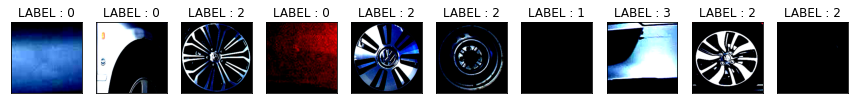

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(15, 4))
for plot_idx in range(10):
    ax[plot_idx].imshow(sample['input'][plot_idx].permute(1, 2, 0))
    ax[plot_idx].set_title('LABEL : {}'.format(sample['label'][plot_idx]))
    ax[plot_idx].set_xticks([])
    ax[plot_idx].set_yticks([])
plt.show()

### Define the Multiple Layer Perceptrons

In [ ]:
class Model(nn.Module):
    def __init__(self, feat_dim=2048, output_dim=4):
        super(Model, self).__init__()

        self.feat_dim = feat_dim
        self.output_dim = output_dim
        self.backbone = torchvision.models.resnet50(pretrained=True)
        # self.backbone.dropout = nn.Dropout(p=0.5)        
        # self.backbone.dropout.fc = nn.Linear(feat_dim, output_dim)  # test accu=0.75
        self.backbone.fc = nn.Linear(feat_dim, output_dim)

    def forward(self, img):
        out = self.backbone(img) 
        return out

### Define the Model

In [ ]:
model = Model()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-7)
print(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Model(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

### Define functions for train/test

In [ ]:
def train(model, optimizer, sample):
    model.train()

    img = sample['input'].float().to(device)
    label = sample['label'].long().to(device) 
    pred = model(img)

    num_correct = sum(torch.argmax(pred, dim=1) == label)
    pred_loss = criterion(pred, label)

    reg_loss = 0.0
    for p in model.parameters():
        if p.requires_grad:
            reg_loss += torch.norm(p, 2)
    
    total_loss = pred_loss + 1e-5*reg_loss
    
    optimizer.zero_grad()
    total_loss.backward()
    # pred_loss.backward()
    optimizer.step()

    return pred_loss.item(), num_correct.item()

In [ ]:
def test(model, sample):
    model.eval()

    with torch.no_grad():
        img = sample['input'].float().to(device)
        label = sample['label'].long().to(device) 

        pred = model(img)
        pred_loss = criterion(pred, label)

        num_correct = sum(torch.argmax(pred, dim=1) == label)

    return pred_loss.item(), num_correct.item()

### Run Training

In [ ]:
model_dir = '/content/drive/MyDrive/AMI/models'    # save model
# os.mkdir(model_dir)
os.chdir('/content/drive/MyDrive/AMI')

max_accu = -1
max_epoch = 40

for epoch in tqdm(range(max_epoch)):        
    ###Train Phase
    
    # Initialize Loss and Accuracy
    train_loss = 0.0
    train_accu = 0.0

    # Iterate over the train_dataloader
    for idx, sample in enumerate(train_dataloader):
        curr_loss, num_correct = train(model, optimizer, sample)
        train_loss += curr_loss / len(train_dataloader)
        train_accu += num_correct / len(train_dataset)

    print(f'epoch: {epoch}, train loss: {train_loss}, train accu: {train_accu}')
    
    # save the model and optimizer's information before the evaulation
    checkpoint = {
        'model' : Model(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }

    ### Test Phase
    # Initialize Loss and Accuracy
    test_loss = 0.0
    test_accu = 0.0

    # Iterate over the test_dataloader
    for idx, sample in enumerate(test_dataloader):
        curr_loss, num_correct = test(model, sample)
        test_loss += curr_loss / len(test_dataloader)
        test_accu += num_correct / len(test_dataloader)

    print(f'epoch: {epoch}, test loss: {test_loss}, test accu: {test_accu}')

    max_accu = max(test_accu, max_accu)
    if max_accu == test_accu:
        # Save your best model to the checkpoint
        torch.save(checkpoint, os.path.join(model_dir, 'ResNet50_best.pth'))
        print('Model has saved.')

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0, train loss: 0.03688440875460704, train accu: 0.99581589958159
epoch: 0, test loss: 0.6473916479002527, test accu: 0.8444444444444424
Model has saved.
epoch: 1, train loss: 0.08912128629162908, train accu: 0.9874476987447699
epoch: 1, test loss: 0.8129110087415786, test accu: 0.7944444444444426
epoch: 2, train loss: 0.12269029874975482, train accu: 0.9762900976290096
epoch: 2, test loss: 0.6469227281586629, test accu: 0.7611111111111094
epoch: 3, train loss: 0.0907667918751637, train accu: 0.9776847977684797
epoch: 3, test loss: 0.7078164268918448, test accu: 0.7944444444444426
epoch: 4, train loss: 0.04744845675304532, train accu: 0.9860529986052997
epoch: 4, test loss: 0.7114717660432839, test accu: 0.8055555555555537
epoch: 5, train loss: 0.03081036948909362, train accu: 0.9902370990237098
epoch: 5, test loss: 0.6913926893411872, test accu: 0.8166666666666648
epoch: 6, train loss: 0.016329399736908574, train accu: 0.9986052998605299
epoch: 6, test loss: 0.7425201286603417, 